<a href="https://colab.research.google.com/github/mingshey/python_mechanics/blob/main/Python%EA%B3%A0%EC%A0%84%EC%97%AD%ED%95%99_013c_Three_and_One_Body.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analytical Mechanics with Python
# 파이썬으로 코딩하는 고전역학


In [ ]:
import numpy as np               # n-차원 배열 계산
from scipy.integrate import solve_ivp  # RK45 등 수치적분에 사용
import matplotlib.pyplot as plt  # 그래프 작성
import matplotlib.animation as animation
from matplotlib.animation import PillowWriter
import scipy as sci

import time

In [ ]:
def addbody(n, m, c, clr):
  '''
  천체 데이타를 배위 정보에 추가하는 함수
  n: 천체의 이름
  m: 천체의 질량
  c: [x, y, z, vx, vy, vz] 천체의 위치와 속도 성분(직교직선좌표)
  clr: 화면에 표시할 천체의 색상 값
  '''
  global names, mass, config, colors
  names = np.append(names, n)
  mass = np.append(mass,m)
  config = np.append(config, c)
  colors = np.append(colors, clr)

In [ ]:
'''
Gravitational Constant
'''
#G = 6.67e-11
G = 1

In [ ]:
a = np.linspace(0,1,60)

In [ ]:
a.shape

(60,)

In [ ]:
def dSdt(t, S):
    '''
    천체들의 현 배위 정보로부터 중력 상호작용을 합성하여
    위치와 속도 성분들의 변화율 (dudt) 를 구한다
    t: 현재 시각 데이타
    u: 현재 배위 데이타
    '''
    u = S.reshape(-1, 6)
    n = len(u)
    dSdt=np.array([])
    for i in range(n):
        r = np.array(u[i][:3])
        v = np.array(u[i][3:])
        a = np.zeros(3)
        for j in range(n):
            if j != i:
                m2 = mass[j]
                r2 = u[j][:3]
                dr = r2 - r
                d3 = np.power((dr * dr).sum(), 1.5)
                a += G * m2 * dr / d3
        dSdt = np.append(dSdt, np.append(v,a))
    return dSdt

In [ ]:
# n번째 천체의 운동 에너지
def get_ken(M, S, n):
  '''
  n번째 천체의 운동 에너지
  '''
  # n 값이 너무 크거나 작으면 에러를 반환한다.
  if n >= len(M) or n < 0:
    raise ValueError(f"n 값은 [0, {len(M)-1}] 범위의 정수이어야 합니다.")
  else:
    v = S.reshape(-1, 6)[n, 3:]    # n번째 천체의 배위 정보 중 뒷부분 3개(속도)를 추출함.
    KE = 0.5 * M[n] * (v**2).sum() # n번째 천체의 운동 에너지

    return KE

# 전체 계의 운동 에너지
def get_kes(M, S):
    '''
    천체들의 현 배위 정보로부터 운동 에너지를 구한다
    M: 천체의 질량
    S: 현재 배위 데이타
    '''
    n = len(M)
    u = S.reshape(-1, 6)[:, 3:]
    E = 0
    for i in range(n):
      E += 0.5 * M[i] * (u[i]**2).sum()

    return E

# 각 천체의 퍼텐셜 에너지
def get_pen(M, S, n):
  '''
  시스템 내 n번째 천체의 퍼텐셜 에너지를 구한다
  M: 천체의 질량
  S: 현재 배위 데이타
  n: 퍼텐셜 에너지를 구하고자 하는 천체의 번호
  '''
  # n 값이 너무 크거나 작으면 에러를 반환한다.
  if n >= len(M) or n < 0:
    raise ValueError(f"n 값은 [0, {len(M)-1}] 범위의 정수이어야 합니다.")
  else:
    q = S.reshape(-1, 6)[:, :3] # 각 천체들의 배위 정보 중 앞부분 3개(좌표 값)를 추출함.
    PE = 0

    # n번째 천체와 나머지 다른 천제들 사이의 퍼텐셜 에너지 합산.
    #    ∑ U(n,i)
    #   i≠n
    #            G Mi Mj
    # U(i,j) = - -------
    #             r_i,j
    for i in range(len(M)):
      if i != n:
        PE += -G*M[n]*M[i]/np.linalg.norm(q[n]-q[i])

    return PE

# 전체 시스템의 퍼텐셜 에너지
def get_pes(M, S):
    '''
    천체들의 현 배위 정보로부터 중력 퍼텐셜 에너지를 구한다
    M: 천체의 질량
    S: 현재 배위 데이타
    '''
    global G
    n = len(M)
    E = 0
    r = S.reshape(-1, 6)[:, :3]
    for i in range(n-1):
      for j in range(i+1,n):
        dr = r[i] - r[j]
        dist = np.sqrt((dr**2).sum())
        E += -G*M[i]*M[j]/dist

    return E

def energy(M, S):
    '''
    천체들의 현 배위 정보로부터 중력 상호작용을 합성하여
    역학적 에너지를 구한다
    M: 천체의 질량
    S: 현재 배위 데이타
    '''
    E = get_kes(M, S) + get_pes(M, S)

    return E

In [ ]:
'''
천체 데이타
'''
#공통 질량과 초기 궤도 반지름, 초기 궤도 속력
m = 1.0; r=1; r1 = 1*r; r2 = 5*r; r3=0.5*r
# (m1)--c1--(m2)----------------(m3)--(mCa)
#  |<---r1-->|
#       |<----------r2---------->|<-r3->|


simname="Tn1B-2" # Three plus One Bodies
simtitle="Three + One Body 2"

Cfactor=0.82
mA = 2*m;
mB = 1*m;
mC = 0.5*m;
mCa = 0.1*mC;
M1 = mA + mB;
Mx = mC + mCa;
M2 = M1 + Mx;
v1 = np.sqrt(G*M1/r1);
v2 = Cfactor * np.sqrt(G*M2/r2);
v3 = np.sqrt(G*(mC+mCa)/r3)
r12 = r2*(mC/M2)
r2a = r2-r12+r3
"A의 좌표, 속도 성분"
xA = -(mB/M1)*r1-(Mx/M2)*r2; yA = 0; zA = 0.0
vxA = 0; vyA = (-mB/M1)*v1 - (Mx/M2)*v2; vzA = 0.0

"B의 좌표, 속도 성분"
xB = (mA/M1)*r1-(Mx/M2)*r2; yB = 0; zB = 0.0
vxB = 0; vyB = (mA/M1)*v1 - (Mx/M2)*v2; vzB = 0.0

"C의 좌표, 속도 성분"
xC = (M1/M2)*r2-(mCa/Mx)*r3; yC = 0.0; zC = 0.0
vxC = 0; vyC = (M1/M2)*v2 - (mCa/Mx)*v3; vzC = 0.0

"Ca의 좌표, 속도 성분"
xCa = xC+r3; yCa=0.0; zCa=0.0
vxCa = 0.0; vyCa = vyC+v3; vzCa = 0.0

"천체의 이름 목록"
names = np.array([]) # List of the mass of celestial bodies

"천체의 질량 목록"
mass = np.array([]) # List of the mass of celestial bodies

"천체의 배위 정보 목록"
config = np.array([]) # initial configuration of the bodies

"시각화에 사용할 천체별 색상 목록"
colors=np.array([])

sA = [xA, yA, zA, vxA, vyA, vzA]
sB = [xB, yB, zB, vxB, vyB, vzB]
sC = [xC, yC, zC, vxC, vyC, vzC]
sCa = [xCa, yCa, zCa, vxCa, vyCa, vzCa]

"천체 데이타를 배위 정보에 차례로 추가한다."
addbody("A", mA, sA, "red")
addbody("B", mB, sB, "green")
addbody("C", mC, sC, "blue")
addbody("Ca", mCa, sCa, "black")

In [ ]:
dSdt(0,config)

array([ 0.        , -0.68439797,  0.        ,  1.01937418,  0.        ,
        0.        ,  0.        ,  1.04765283,  0.        , -1.97062411,
        0.        ,  0.        ,  0.        ,  0.48855032,  0.        ,
        0.074084  ,  0.        ,  0.        ,  0.        ,  1.53735917,
        0.        , -2.10332513,  0.        ,  0.        ])

In [ ]:
get_pes(mass, config)

np.float64(-2.3834400465882712)

In [ ]:
get_kes(mass, config)

np.float64(1.1359459999999997)

In [ ]:
E0 = energy(mass, config)
E0

np.float64(-1.2474940465882716)

In [ ]:
mass

array([2.  , 1.  , 0.5 , 0.05])

In [ ]:
mA*np.array(sA) + mB*np.array(sB) + mC*np.array(sC) + mCa*np.array(sCa)

array([ 1.11022302e-16,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
       -1.38777878e-17,  0.00000000e+00])

In [ ]:
'''
시뮬레이션을 진행한다.
scipy.integrate의 solve_ivp 함수를 이용
fun <- dSdt
t0 <- t0
y0 <- config
t_bound <- tb
max_step <- dt
... etc. ...
'''
"시뮬레이션 시작 시각"
t0 = 0     # Starting time of simulation

"시뮬레이션 종료 시각"
tb = 300   # Bounding time of simulation

N = 3000

"시간 영역을 저장할 리스트:"
td = np.linspace(t0, tb, N+1)
Dt = np.diff(td)[0]

"최대 시간 간격"

smethod="Radau"

start_time = time.time()
sol = solve_ivp(dSdt, (t0, tb), config, t_eval=td, max_step=1.0, method=smethod)
end_time = time.time()

print(f"Elapsed time: {end_time - start_time} seconds")

Elapsed time: 7.905914306640625 seconds


In [ ]:
cnum = len(mass)

In [ ]:
N = len(sol.t)
N

3001

In [ ]:
ts = sol.t

In [ ]:
sol.y.T

array([[-1.10798122,  0.        ,  0.        , ...,  0.        ,
         1.53735917,  0.        ],
       [-1.1028985 , -0.06815136,  0.        , ..., -0.20884983,
         1.51634037,  0.        ],
       [-1.08779278, -0.13457805,  0.        , ..., -0.40887986,
         1.4542311 ,  0.        ],
       ...,
       [ 0.93968043, -3.06129068,  0.        , ..., -0.94999019,
         1.69953493,  0.        ],
       [ 0.94165491, -3.13817646,  0.        , ..., -0.94998718,
         1.69952933,  0.        ],
       [ 0.95626526, -3.21655159,  0.        , ..., -0.94998417,
         1.69952375,  0.        ]])

## 역학적 에너지
총 역학적 에너지가 초기 값에 비해 얼마나 변하는지 확인한다.
역학적 에너지 변화가 눈에 띌 만큼 크다면 시뮬레이션의 정확성이 떨어짐을 의미한다.

In [ ]:
N

3001

In [ ]:
sol.y.T[2]

array([-1.08779278, -0.13457805,  0.        ,  0.19988048, -0.65001939,
        0.        , -0.14699678,  0.20493525,  0.        , -0.38615928,
        0.97901345,  0.        ,  4.18132274,  0.09825229,  0.        ,
        0.01368464,  0.49662753,  0.        ,  4.63841943,  0.30189394,
        0.        , -0.40887986,  1.4542311 ,  0.        ])

In [ ]:
KEs = np.array([get_kes(mass, sol.y.T[i]) for i in range(N)])
PEs = np.array([get_pes(mass, sol.y.T[i]) for i in range(N)])
Es = KEs + PEs

In [ ]:
Es.min()/E0, Es.max()/E0, (Es.max()-Es.min())/E0

(np.float64(1.0181192532614187),
 np.float64(0.9996617181081391),
 np.float64(-0.018457535153279733))

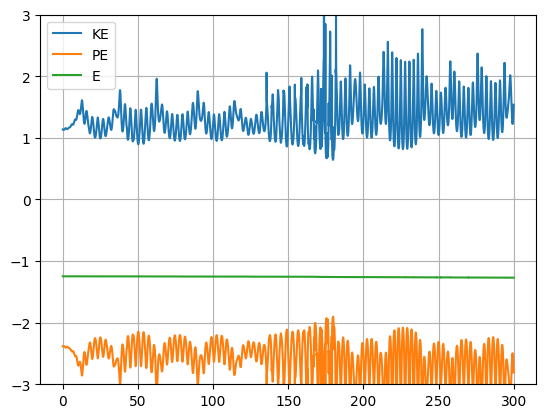

In [ ]:
plt.grid()
# plt.xlim(0,25)
plt.ylim(-3,3)
plt.plot(ts, KEs, label="KE")
plt.plot(ts, PEs, label="PE")
plt.plot(ts, Es, label="E")
plt.legend()
plt.savefig(f"{simname:s}-Energy.png")

In [ ]:
# 시뮬레이션 데이터를 각각의 천체에 대하여 그룹으로 묶고,
# 각각의 그룹은 6개의 배위 정보로,
# 각각의 배위 정보는 시간에 따른 배열로 재구성한다:
# 'cb' for 'celestial bodies'
cb = sol.y.reshape((len(mass), 6, len(ts)))
np.shape(cb)

(4, 6, 3001)

In [ ]:
cb[0][0]

array([-1.10798122, -1.1028985 , -1.08779278, ...,  0.93968043,
        0.94165491,  0.95626526])

In [ ]:
N = len(ts)
N

3001

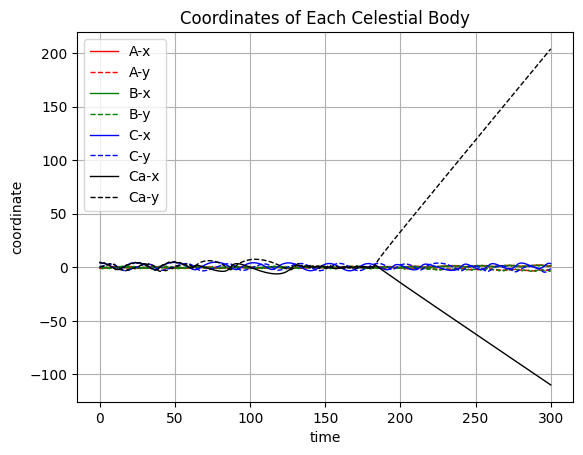

In [ ]:
plt.title("Coordinates of Each Celestial Body")
plt.grid()
plt.xlabel("time")
plt.ylabel("coordinate")

for k in range(cnum):
  plt.plot(ts, cb[k][0], label = f'{names[k]}-x', c=colors[k], ls="solid", lw=1)
  plt.plot(ts, cb[k][1], label = f'{names[k]}-y', c=colors[k], ls="dashed", lw=1)

plt.legend()
plt.savefig(f"{simname:s}-Coords.png", dpi=300)

In [ ]:
KE3 = np.array([get_ken(mass, sol.y.T[k], 3) for k in range(N)])
PE3 = np.array([get_pen(mass, sol.y.T[k], 3) for k in range(N)])

ME3 = KE3 + PE3
print(f"Initial ME3 = {PE3[0]+KE3[0]}, Final ME3 = {PE3[-1]+KE3[-1]}")

Initial ME3 = -0.01863369482452449, Final ME3 = 0.0940264685273412


<Figure size 640x480 with 0 Axes>

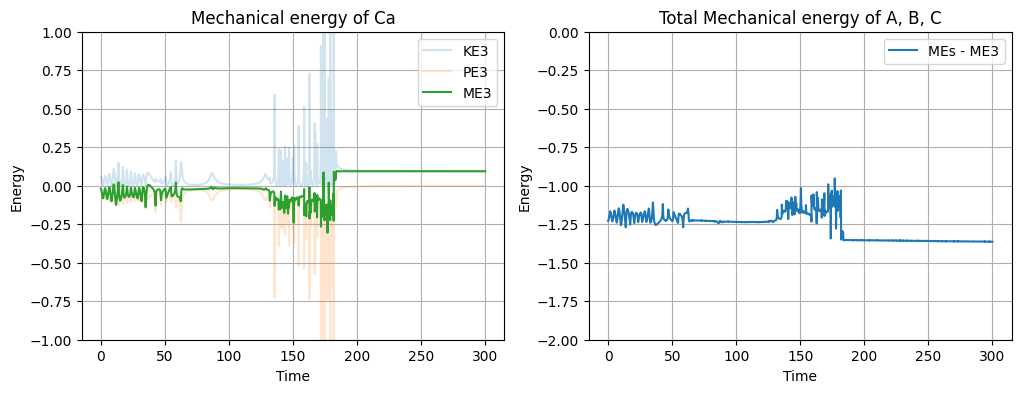

In [ ]:
plt.tight_layout()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].set_title("Mechanical energy of Ca")
ax[0].grid()
ax[0].set_ylim([-1, 1])
ax[0].plot(ts, KE3, label="KE3", alpha=0.2)
ax[0].plot(ts, PE3, label="PE3", alpha=0.2)
ax[0].plot(ts, ME3, label="ME3")
ax[0].set_xlabel("Time")
ax[0].set_ylabel("Energy")
ax[0].legend()

ax[1].set_title("Total Mechanical energy of A, B, C")
ax[1].grid()
ax[1].set_ylim([-2, 0])
# ax[1].plot(ts, PEs - PE3, label="PEs - PE3", alpha=0.2)
# ax[1].plot(ts, KEs - KE3, label="KEs - KE3", alpha=0.2)
ax[1].plot(ts, Es - ME3, label="MEs - ME3")
ax[1].set_xlabel("Time")
ax[1].set_ylabel("Energy")
ax[1].legend()

plt.savefig(f"{simname:s}-ME3.png", dpi=300)

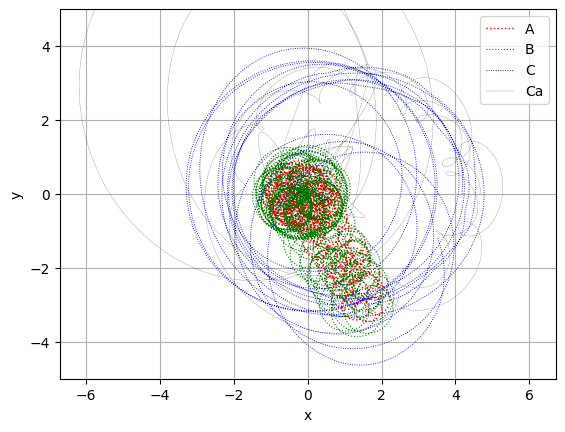

In [ ]:
"천체들의 궤적을 (x,y) 좌표상에 그려본다"
plt.axis('equal')
plt.grid()
rad=5
plt.xlim(-rad, rad)
plt.ylim(-rad,rad)
bgn=0
end=N
plt.xlabel("x")
plt.ylabel("y")
for k in range(cnum):
  plt.plot(cb[k][0][bgn:end], cb[k][1][bgn:end],
           c=colors[k],
           alpha=1.0,
           ms=0,
           lw=(mass[k]/np.max(mass))**(1/3),
           ls='dotted',
           label=names[k])
plt.legend()

plt.savefig(f"{simname:s}-Orbits.png", dpi=300)

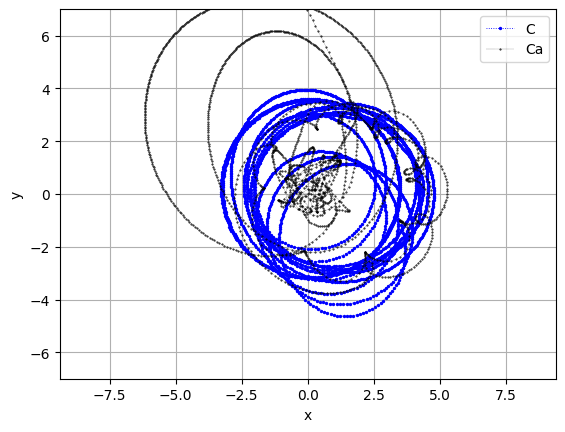

In [ ]:
"천체들의 궤적을 (x,y) 좌표상에 그려본다"
plt.axis('equal')
plt.grid()
rad=7
plt.xlim(-rad, rad)
plt.ylim(-rad,rad)
bgn=0
end=N
msscale=2
plt.xlabel("x")
plt.ylabel("y")
for k in [2, 3]:
  plt.plot(cb[k][0][bgn:end], cb[k][1][bgn:end],
    c = colors[k],
    alpha = 1.0,
    marker='o',
    ms = np.sqrt(mass[k])*msscale,
    lw = (mass[k]/np.max(mass))**(1/3),
    ls = 'dotted',
    label = names[k])
plt.legend()

plt.savefig(f"{simname:s}-Orbits.png", dpi=300)

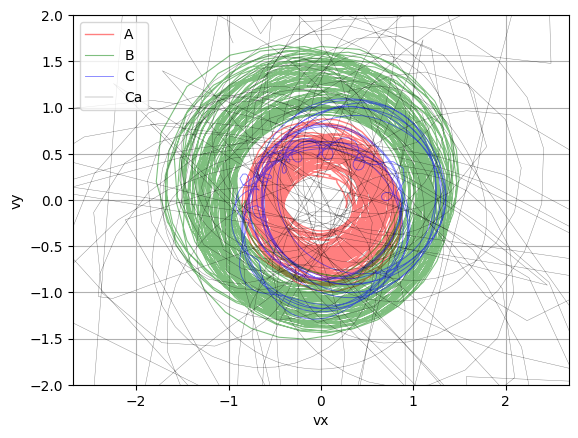

In [ ]:
"천체들의 호도그래프를 (vx, vy) 좌표상에 그려본다"
plt.axis('equal')
plt.grid()
rad=2
plt.xlim(-rad, rad)
plt.ylim(-rad,rad)
bgn=0
end=N
plt.xlabel("vx")
plt.ylabel("vy")
for k in range(cnum):
  plt.plot(cb[k][3][bgn:end], cb[k][4][bgn:end],
           c=colors[k],
           alpha=0.5,
           ms=0,
           lw=(mass[k]/np.max(mass))**(1/3),
           label=names[k])
plt.legend()

plt.savefig(f"{simname:s}-Orbits.png", dpi=300)

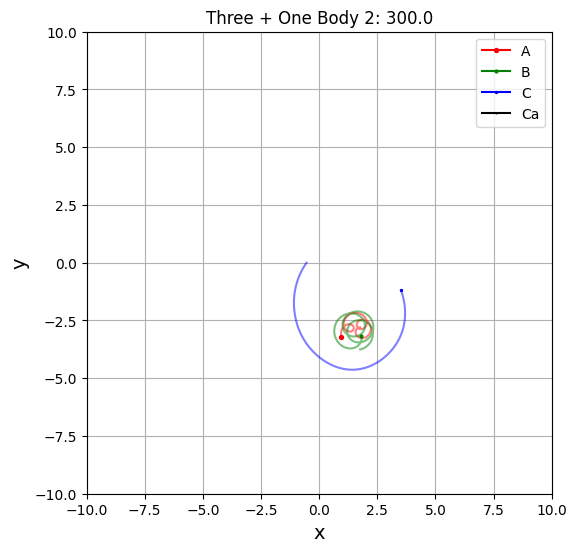

In [ ]:
"""
동영상에 사용할 그림을 작성하는 함수
"""

def frame(i, draw_velocity=False):
  rad=10.0
  minx = -rad
  maxx = rad
  miny = -rad
  maxy = rad
  ax.grid()
  msscale=2

  tail_len = 100
  istart = np.maximum(0,i-tail_len)
  iend = np.minimum(i+1,len(ts))
  ax.cla()
  ax.set_xlim(minx,maxx)
  ax.set_xlabel('x', fontsize = 14)
  ax.set_ylim(miny,maxy)
  ax.set_ylabel('y', fontsize = 14)
  ax.grid()
  ax.set_title(f"{simtitle:s}: {td[i]:.1f}")
  for k in range(cnum):
      ax.plot(cb[k][0][istart:iend], cb[k][1][istart:iend], color = colors[k], alpha=0.5)
      ax.plot(cb[k][0][i], cb[k][1][i], color = colors[k], marker='o', ms=np.sqrt(mass[k])*msscale, label=names[k])
  ax.legend()

  if draw_velocity==True:
    ax.quiver(cb[:,0,i], cb[:,1,i], cb[:,3,i], cb[:,4,i], angles='xy', scale_units='xy', scale=1)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))
frame(N-1, draw_velocity=False)

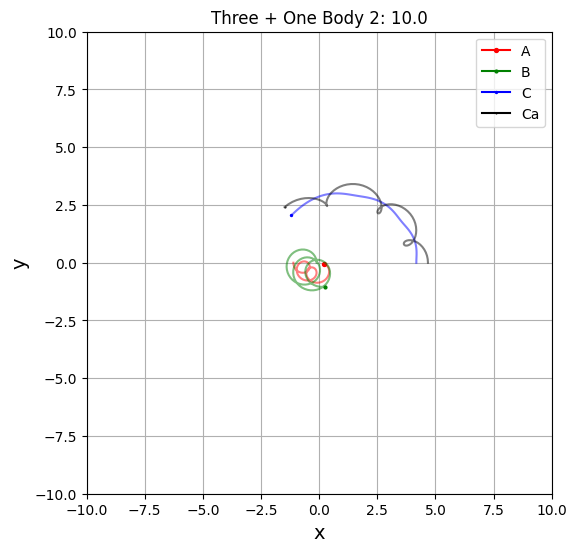

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.grid()
frame(100)

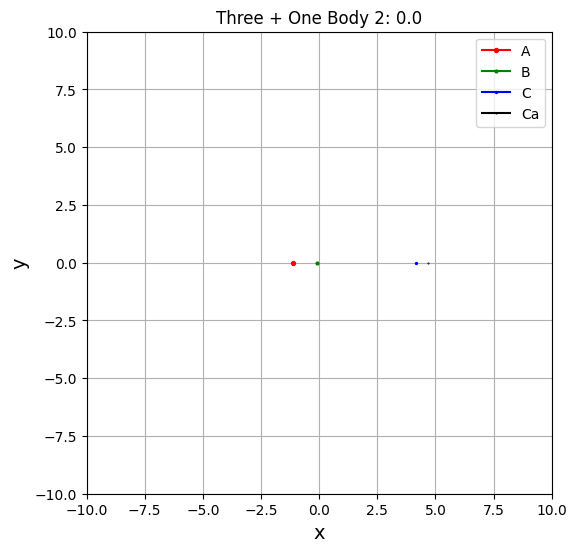

In [ ]:
N1=2000
# N1=100 # for test purpose
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ani = animation.FuncAnimation(fig, frame, frames=N1)

In [ ]:
fname=f'{simname:s}-{smethod:s}-n{N1:d}.gif'

print("Saving GIF file...")
start_time = time.time()
ani.save(fname, writer="pillow", fps=15, dpi=150)
end_time = time.time()
print(f"Animation saved to {fname:s}.")

print(f"Elapsed time: {end_time - start_time} seconds")

Saving GIF file...
Animation saved to Tn1B-2-Radau-n2000.gif.
Elapsed time: 559.252459526062 seconds


In [ ]:
fname=f'{simname:s}-{smethod:s}-n{N1:d}.mpeg'

print("Saving MPEG file...")
start_time = time.time()
ani.save(fname, fps=15, dpi=150)
end_time = time.time()
print(f"Animation saved to {fname:s}.")

print(f"Elapsed time: {end_time - start_time} seconds")

Saving MPEG file...
Animation saved to Tn1B-2-Radau-n2000.mpeg.
Elapsed time: 337.5128002166748 seconds
